# Laboratory work №4

### Maslennikova Elizaveta, Shchegletova Tatyana 18IAD

#### loss = :top1, opt = :sgdm, agg = :sum, constr = :nneg

In [1]:
import pandas as pd
import numpy as np
from pymystem3 import Mystem
from sklearn.feature_extraction.text import CountVectorizer
import re 
import nltk
import sys
nltk.download('stopwords')
from nltk.corpus import stopwords 
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/elizavetamaslennikova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import warnings
warnings.filterwarnings("ignore")

### Reading data 

In [3]:
data = pd.read_json('final.json')
data.index = range(0, data.shape[0])
data.head()

,text,title
0,"Телеведущая Ксения Собчак считает, что художе...","Серебренников создал не просто театр, а ""центр..."
1,Интернет-сервис Amazo удалил с сайта объявлени...,"Американка сняла на видео ""профессиональный"" ф..."
2,Посольство России в Вашингтоне готово оказать...,Посольство России призвало США прекратить похи...
3,"В четверг стало известно, что российский боксе...",Тренер Гассиева: повторный бой с Лебедевым ста...
4,Апелляционный суд Киева отпустил из-под арест...,Суд отпустил из-под ареста подозреваемых в под...


In [4]:
data.shape

(103132, 2)

In [5]:
data.describe()

,text,title
count,103132,103132
unique,103132,103132
top,"""РБ Лейпциг"" в гостях обыграл ""Боруссию"" из Ме...","""Спартак"" объяснил причины отставки Карреры"
freq,1,1


As we can see, data does not have _gaps_ and _duplicates_!

#### Process source texts: cleaning, create vocabulary and translate texts to index sequences

In [6]:
title_texts = pd.concat([data['title'], data["text"]], ignore_index=True)
title_texts.shape

(206264,)

In [7]:
nltk.download('stopwords')

def tokenize(string):
    string = re.sub(r'\W', ' ',  string)
    string = re.sub(r'\s+', ' ', string, flags=re.I)
    tokens = re.findall(r'\b[А-Яа-я]{1,}\b', string)
    words = [t for t in tokens if len(t) > 2]
    return words

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/elizavetamaslennikova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
vectorizer = CountVectorizer(
    tokenizer = tokenize,
    min_df = 10, 
    max_df = 0.5,
    stop_words=stopwords.words('russian'))

vectorizer.fit(title_texts)
pass

In [9]:
vocabulary = vectorizer.vocabulary_

In [10]:
list(vocabulary.items())[:10]

[('серебренников', 22251),
 ('создал', 23173),
 ('просто', 19753),
 ('театр', 24677),
 ('центр', 27397),
 ('силы', 22387),
 ('считает', 24439),
 ('собчак', 23003),
 ('американка', 524),
 ('сняла', 22918)]

In [11]:
ind_to_word = {}
for w, i in vocabulary.items():
    ind_to_word[i] = w
list(ind_to_word.items())[:10]

[(22251, 'серебренников'),
 (23173, 'создал'),
 (19753, 'просто'),
 (24677, 'театр'),
 (27397, 'центр'),
 (22387, 'силы'),
 (24439, 'считает'),
 (23003, 'собчак'),
 (524, 'американка'),
 (22918, 'сняла')]

In [12]:
n_tokens = len(vocabulary.items())
n_tokens

28794

In [13]:
title_tok = vectorizer.transform(data['title'])
text_tok = vectorizer.transform(data['text'])

In [14]:
processed_data = []

for i in range(0, data.shape[0]):
    title = title_tok.getrow(i)
    title_ind = np.array([], dtype=np.uint16)
    for ind, n in zip(title.indices, title.data):
        title_ind = np.append(title_ind, [ind for _ in range(0, n)])
        
    text = text_tok.getrow(i)
    text_ind = np.array([], dtype=np.uint16)
    for ind, n in zip(text.indices, text.data):
        text_ind = np.append(text_ind, [ind for _ in range(0, n)])
    processed_data.append((title_ind, text_ind))
np.random.shuffle(processed_data)

#### Split data to train (100 000 items) and test (1 000) samples 

In [15]:
train_data = processed_data[:100000]
test_data = processed_data[100000:101000]
print(len(train_data), len(test_data))

100000 1000


### Create embedding

W - matrix (_embedding length_ X _number of tokens_), where each column is the representation of certain token in current embedding.

w_T - transpose matrix of W.

Initialize this matrix with random number from Normal distribution.

Also create dictionary with _"momentum"_ for _SGDM_, initialize them with 0.

In [16]:
embending_size = 512

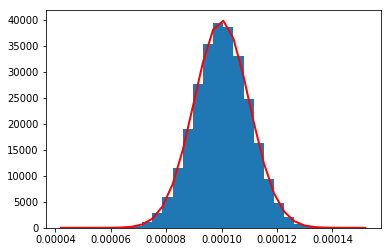

In [17]:
mu, sigma = 0.0001, 0.00001
d = np.random.normal(mu, sigma, embending_size*n_tokens)
count, bins, ignored = plt.hist(d, 30, normed=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.show()

#### Save initial content of w_T to have possibilities to compare different model, starting training from the same

In [18]:
def reset_parameters(d):
    w_T = np.array(d)
    w_T = np.reshape(w_T, newshape=(n_tokens, embending_size))
    vt = np.zeros((n_tokens, embending_size), dtype=np.float16)
    return w_T, vt

In [19]:
w_T, vt = reset_parameters(d)
w_T

array([[9.05917611e-05, 8.67349056e-05, 1.04476539e-04, ...,
        1.14883331e-04, 1.02696145e-04, 1.03682746e-04],
       [1.05765853e-04, 9.80767469e-05, 1.16110870e-04, ...,
        1.13469893e-04, 9.57290019e-05, 1.06738082e-04],
       [1.03072533e-04, 9.58833665e-05, 1.24844576e-04, ...,
        1.07947299e-04, 9.46681303e-05, 1.08937727e-04],
       ...,
       [8.16514846e-05, 9.34682344e-05, 7.96504823e-05, ...,
        1.12455639e-04, 1.04720596e-04, 8.22992181e-05],
       [1.08785344e-04, 9.90305408e-05, 9.42742211e-05, ...,
        1.19177877e-04, 1.01435654e-04, 1.10425052e-04],
       [9.56476373e-05, 8.42283548e-05, 1.23528504e-04, ...,
        9.36585519e-05, 8.42190578e-05, 1.01186373e-04]])

In [20]:
vt

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float16)

## Start training 

In [21]:
# aggrigation function 
def aggr(w_T, text):
    return np.sum(w_T[text], axis=0)

In [22]:
# calculating Sigmoid function
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [23]:
# calculate top1 loss function 
def loss(u, v1, v2):
    arg = np.dot(u, v1) - np.dot(u, v2)
    return sigmoid(arg)

In [24]:
# function for updating weights in embedding
def update(w_T, vt, grad, text, gamma=0.9, learning_rate=0.01):
    vt[text] = gamma*vt[text] + learning_rate*grad
    w_T[text] += vt[text]
    return w_T, vt

In [25]:
# calculate cosine simylarity
def cos_simularity(v1, v2):
    return np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

In [26]:
# check constraints on w_T and update it if they are not executed
def check_constraints(w_T):
    w_T = np.where(w_T < 0, 0.00000001, w_T)
    return w_T

In [27]:
# train 1 epoch
def train(train_data, w_T, vt, gamma, learning_rate, constraints):
    data_number = len(train_data)
    np.random.shuffle(train_data)
    
    for i in range(0, data_number):
        # choose text for training
        true_ind = i
        false_ind = np.random.randint(data_number)
        while false_ind == true_ind:
            false_ind = np.random.randint(data_number)
            
        # aggrigation    
        true_text = aggr(w_T, train_data[true_ind][1])
        true_title = aggr(w_T, train_data[true_ind][0])
        false_text = aggr(w_T, train_data[false_ind][1])
        
        # evaluate top1 loss function
        loss_val = loss(true_title, true_text, false_text)
        
        # upgrade weights
        k = loss_val*(1-loss_val)
        gradients = (k*(true_text-false_text), k*true_title, k*np.negative(true_title))
        texts = (train_data[true_ind][0], train_data[true_ind][1], train_data[false_ind][1])
        for grad, text in zip(gradients, texts):
            w_T, vt = update(w_T, vt, grad, text, gamma, learning_rate)
            
        # check constraints
        if constraints and i % 1000 == 0:
            w_T = check_constraints(w_T)
        
        if i%20 == 19:
            sys.stdout.write("\rTraining: %f%%" % (100*(i+1)/data_number))
            sys.stdout.flush()

    return w_T, vt

In [28]:
# calculate frecuency
def evaluate(test_data, w_T, k=10):
    count = 0
    data_number = len(test_data)
    texts_aggr = []
    for i in range(0, data_number):
        texts_aggr.append(aggr(w_T, test_data[i][1]))
    for ind_1 in range(0, data_number):
        dist_arr = np.array([], dtype=np.float16)
        title_aggr = aggr(w_T, test_data[ind_1][0])
        for ind_2 in range(0, data_number):
            dist_arr = np.append(dist_arr, 1 - cos_simularity(title_aggr, texts_aggr[ind_2]))

        sort_dist_arr = np.sort(dist_arr)
        treshold = sort_dist_arr[k-1]
        if dist_arr[ind_1] <= treshold:
            count += 1

        if ind_1 % 20 == 19:
            sys.stdout.write("\rEvaluate frecuency: %f%%" % (100*(ind_1+1)/data_number))
            sys.stdout.flush()
    return count / data_number

In [29]:
# train model on current number of epoch and calculate frecuency after each of them
def train_model(train_data, test_data, w_T, vt, n_epoch=1, gamma=0.9, learning_rate=0.01, constraints=True):
    frec_arr = []
    for ep in range(0, n_epoch):
        w_T, vt = train(train_data, w_T, vt, gamma, learning_rate, constraints)
        frecuency = evaluate(test_data, w_T)
        print("\rEpoch #" + str(ep) + ": frecuency is %f" %round(frecuency, 2))
        frec_arr.append(frecuency)
    return frec_arr

## Explore model with different set of parametrs (gamma and learning rate) 

In [34]:
w_T, vt = reset_parameters(d)
frec_arr_1 = train_model(train_data, test_data, w_T, vt, n_epoch=15, gamma=0.9, learning_rate=0.01)

Epoch #0: frecuency is 0.410000
Epoch #1: frecuency is 0.540000
Epoch #2: frecuency is 0.590000
Epoch #3: frecuency is 0.640000
Epoch #4: frecuency is 0.660000
Epoch #5: frecuency is 0.680000
Epoch #6: frecuency is 0.710000
Epoch #7: frecuency is 0.720000
Epoch #8: frecuency is 0.740000
Epoch #9: frecuency is 0.740000
Epoch #10: frecuency is 0.770000
Epoch #11: frecuency is 0.760000
Epoch #12: frecuency is 0.770000
Epoch #13: frecuency is 0.780000
Epoch #14: frecuency is 0.780000


In [32]:
w_T, vt = reset_parameters(d)
frec_arr_2 = train_model(train_data, test_data, w_T, vt, n_epoch=15, gamma=0.9, learning_rate=0.1)

Epoch #0: frecuency is 0.190000
Epoch #1: frecuency is 0.210000
Epoch #2: frecuency is 0.230000
Epoch #3: frecuency is 0.220000
Epoch #4: frecuency is 0.230000
Epoch #5: frecuency is 0.240000
Epoch #6: frecuency is 0.240000
Epoch #7: frecuency is 0.230000
Epoch #8: frecuency is 0.220000
Epoch #9: frecuency is 0.240000
Epoch #10: frecuency is 0.230000
Epoch #11: frecuency is 0.240000
Epoch #12: frecuency is 0.220000
Epoch #13: frecuency is 0.230000
Epoch #14: frecuency is 0.210000


In [35]:
w_T, vt = reset_parameters(d)
frec_arr_3 = train_model(train_data, test_data, w_T, vt, n_epoch=15, gamma=0.9, learning_rate=0.001)

Epoch #0: frecuency is 0.120000
Epoch #1: frecuency is 0.150000
Epoch #2: frecuency is 0.200000
Epoch #3: frecuency is 0.240000
Epoch #4: frecuency is 0.290000
Epoch #5: frecuency is 0.330000
Epoch #6: frecuency is 0.380000
Epoch #7: frecuency is 0.410000
Epoch #8: frecuency is 0.420000
Epoch #9: frecuency is 0.460000
Epoch #10: frecuency is 0.470000
Epoch #11: frecuency is 0.490000
Epoch #12: frecuency is 0.490000
Epoch #13: frecuency is 0.500000
Epoch #14: frecuency is 0.510000


In [54]:
w_T, vt = reset_parameters(d)
frec_arr_6 = train_model(train_data, test_data, w_T, vt, n_epoch=15, gamma=0.99, learning_rate=0.01)

Epoch #0: frecuency is 0.230000
Epoch #1: frecuency is 0.210000
Epoch #2: frecuency is 0.230000
Epoch #3: frecuency is 0.220000
Epoch #4: frecuency is 0.230000
Epoch #5: frecuency is 0.220000
Epoch #6: frecuency is 0.240000
Epoch #7: frecuency is 0.240000
Epoch #8: frecuency is 0.240000
Epoch #9: frecuency is 0.260000
Epoch #10: frecuency is 0.270000
Epoch #11: frecuency is 0.290000
Epoch #12: frecuency is 0.290000
Epoch #13: frecuency is 0.270000
Epoch #14: frecuency is 0.270000


In [36]:
w_T, vt = reset_parameters(d)
frec_arr_4 = train_model(train_data, test_data, w_T, vt, n_epoch=15, gamma=0.5, learning_rate=0.01)

Epoch #0: frecuency is 0.180000
Epoch #1: frecuency is 0.300000
Epoch #2: frecuency is 0.390000
Epoch #3: frecuency is 0.440000
Epoch #4: frecuency is 0.470000
Epoch #5: frecuency is 0.510000
Epoch #6: frecuency is 0.530000
Epoch #7: frecuency is 0.540000
Epoch #8: frecuency is 0.570000
Epoch #9: frecuency is 0.580000
Epoch #10: frecuency is 0.590000
Epoch #11: frecuency is 0.610000
Epoch #12: frecuency is 0.630000
Epoch #13: frecuency is 0.640000
Epoch #14: frecuency is 0.650000


In [38]:
w_T, vt = reset_parameters(d)
frec_arr_5 = train_model(train_data, test_data, w_T, vt, n_epoch=15, gamma=0.1, learning_rate=0.01)

Epoch #0: frecuency is 0.140000
Epoch #1: frecuency is 0.190000
Epoch #2: frecuency is 0.240000
Epoch #3: frecuency is 0.300000
Epoch #4: frecuency is 0.340000
Epoch #5: frecuency is 0.390000
Epoch #6: frecuency is 0.420000
Epoch #7: frecuency is 0.440000
Epoch #8: frecuency is 0.460000
Epoch #9: frecuency is 0.480000
Epoch #10: frecuency is 0.490000
Epoch #11: frecuency is 0.500000
Epoch #12: frecuency is 0.520000
Epoch #13: frecuency is 0.530000
Epoch #14: frecuency is 0.540000


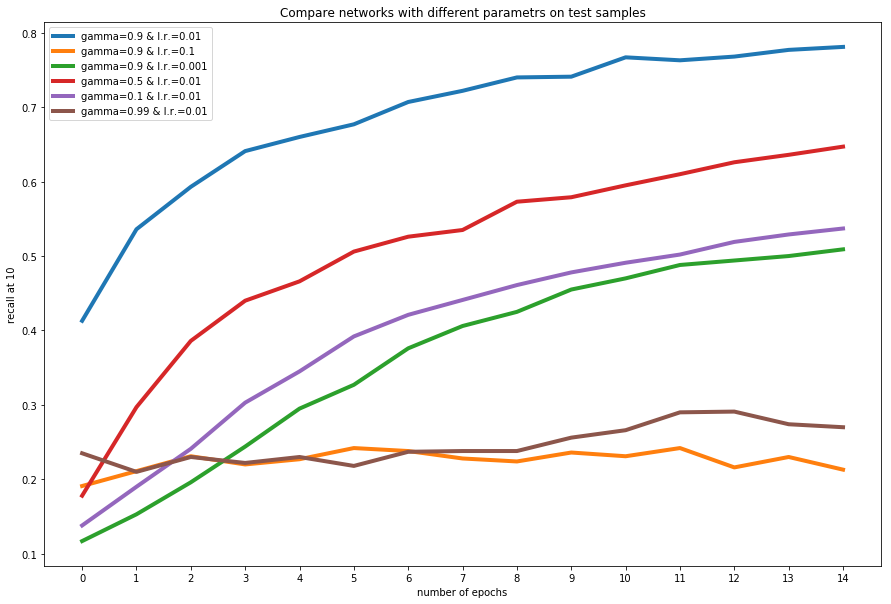

In [55]:
epoch_arr = np.arange(0, 15)
plt.figure(figsize = (15, 10))

plt.plot(epoch_arr, frec_arr_1, label = 'gamma=0.9 & l.r.=0.01', linewidth=4.0)
plt.plot(epoch_arr, frec_arr_2, label = 'gamma=0.9 & l.r.=0.1', linewidth=4.0)
plt.plot(epoch_arr, frec_arr_3, label = 'gamma=0.9 & l.r.=0.001', linewidth=4.0)
plt.plot(epoch_arr, frec_arr_4, label = 'gamma=0.5 & l.r.=0.01', linewidth=4.0)
plt.plot(epoch_arr, frec_arr_5, label = 'gamma=0.1 & l.r.=0.01', linewidth=4.0)
plt.plot(epoch_arr, frec_arr_6, label = 'gamma=0.99 & l.r.=0.01', linewidth=4.0)

plt.title('Compare networks with different parametrs on test samples')
plt.xlabel('number of epochs')
plt.ylabel('recall at 10')
plt.xticks(epoch_arr)
plt.legend()

#### As you can see from the plot, the best model for this data is model with gamma=0.9 and learning_rate=0.01

#### Now we try to train this model while frecuency on test score will increase

In [93]:
def train_best_model(train_data, test_data, w_T, vt, gamma=0.9, learning_rate=0.01, constraints=True):
    frec_arr = []
    w_T_best = None
    s = 0
    last_freac = 0
    ep = 0
    while last_freac < 1 and s < 3:
        w_T, vt = train(train_data, w_T, vt, gamma, learning_rate, constraints)
        frecuency = evaluate(test_data, w_T)
        print("\rEpoch #" + str(ep) + ": frecuency is %f" %round(frecuency, 2))
        if frecuency - last_freac < 0.005:
            s += 1
        else:
            w_T_best = w_T 
            if s > 0:
                s = 0
        frec_arr.append(frecuency)
        last_freac = frecuency
        ep += 1
    return frec_arr, w_T_best

In [94]:
w_T, vt = reset_parameters(d)
frec_arr_best, w_T_best = train_best_model(train_data, test_data, w_T, vt, gamma=0.9, learning_rate=0.01)

Epoch #0: frecuency is 0.410000
Epoch #1: frecuency is 0.530000
Epoch #2: frecuency is 0.560000
Epoch #3: frecuency is 0.600000
Epoch #4: frecuency is 0.630000
Epoch #5: frecuency is 0.670000
Epoch #6: frecuency is 0.690000
Epoch #7: frecuency is 0.690000
Epoch #8: frecuency is 0.700000
Epoch #9: frecuency is 0.700000
Epoch #10: frecuency is 0.720000
Epoch #11: frecuency is 0.730000
Epoch #12: frecuency is 0.740000
Epoch #13: frecuency is 0.750000
Epoch #14: frecuency is 0.760000
Epoch #15: frecuency is 0.770000
Epoch #16: frecuency is 0.770000
Epoch #17: frecuency is 0.770000
Epoch #18: frecuency is 0.780000
Epoch #19: frecuency is 0.770000
Epoch #20: frecuency is 0.780000
Epoch #21: frecuency is 0.790000
Epoch #22: frecuency is 0.800000
Epoch #23: frecuency is 0.800000
Epoch #24: frecuency is 0.800000
Epoch #25: frecuency is 0.800000
Epoch #26: frecuency is 0.810000
Epoch #27: frecuency is 0.810000
Epoch #28: frecuency is 0.810000
Epoch #29: frecuency is 0.810000


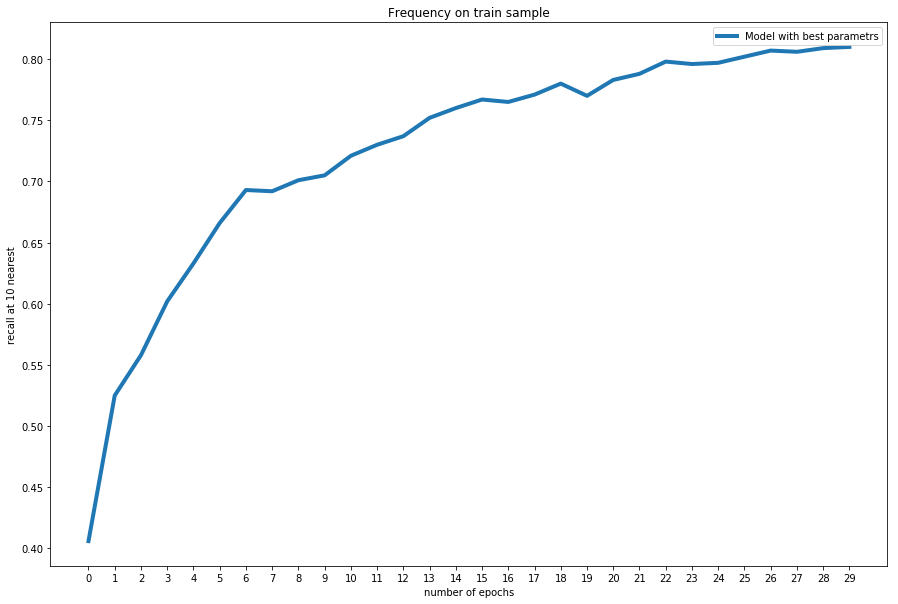

In [95]:
epoch_arr = np.arange(0, len(frec_arr_best))
plt.figure(figsize = (15, 10))

plt.plot(epoch_arr, frec_arr_best, label = 'Model with best parametrs', linewidth=4.0)

plt.title('Frequency on train sample')
plt.xlabel('number of epochs')
plt.ylabel('recall at 10 nearest')
plt.xticks(epoch_arr)
plt.legend()

#### Explore the final embedding by finding the nearest words for the current one

In [101]:
# find neighboring for words
def knn(w_T, ind, k=10):
    dist_arr = []
    for i in range(0, w_T.shape[0]):
        dist_arr.append((i, 1 - cos_simularity(w_T[ind], w_T[i])))
    dist_arr = np.array(dist_arr, dtype=[('index', int), ('dist', float)])
    dist_arr = np.sort(dist_arr, order='dist') 
    print("Input world -", ind_to_word[ind])
    print("Neighbors:")
    for j in range(0, k):
        if dist_arr[j]['index'] != ind:
            print("\t" + ind_to_word[dist_arr[j]['index']])

In [102]:
word_index = vocabulary.get("сбербанк", None)
if word_index is not None:
    knn(w_T_best, word_index)

Input world - сбербанк
Neighbors:
	дочерняя
	процентного
	повысил
	вкладов
	лишившегося
	ипотеку
	сгк
	производство
	цен


In [104]:
word_index = vocabulary.get("путина", None)
if word_index is not None:
    knn(w_T_best, word_index)

Input world - путина
Neighbors:
	путиным
	адекватный
	владимира
	владимиру
	путину
	надзора
	приеме
	майского
	награждении


In [107]:
word_index = vocabulary.get("пожарный", None)
if word_index is not None:
    knn(w_T_best, word_index)

Input world - пожарный
Neighbors:
	эвакуации
	кировском
	авиалиний
	склад
	превышения
	мусорных
	реальную
	кровли
	локализован


In [108]:
word_index = vocabulary.get("трагедия", None)
if word_index is not None:
    knn(w_T_best, word_index)

Input world - трагедия
Neighbors:
	кизляре
	пострадавшие
	израильтяне
	находятся
	пищу
	уточняет
	торнадо
	муниципалитете
	грозном


In [110]:
word_index = vocabulary.get("награждения", None)
if word_index is not None:
    knn(w_T_best, word_index)

Input world - награждения
Neighbors:
	выпускающий
	переезда
	церемонию
	лауреата
	финская
	хип
	летающие
	посмотрел
	гоголь


In [111]:
word_index = vocabulary.get("балет", None)
if word_index is not None:
    knn(w_T_best, word_index)

Input world - балет
Neighbors:
	союзмультфильм
	хабенского
	хворостовского
	тотальный
	художником
	искусство
	фотоленте
	развлечений
	хантер


In [113]:
word_index = vocabulary.get("экономика", None)
if word_index is not None:
    knn(w_T_best, word_index)

Input world - экономика
Neighbors:
	цифровая
	рыбной
	капитала
	шувалов
	доступности
	мень
	замминистра
	апк
	импортных
